![header](../figures/logos_partenaires._cmems_se.jpg)


<div class="alert alert-block alert-success">
<h1><center> Structural Similarities over 1day repeat </center></h1></div>

***
**Authors:**  Datlas, IGE, IMEDEA & CLS <br>
**Copyright:** 2022 Datlas, IGE, IMEDEA & CLS <br>
**License:** MIT

## Structural similarities (SSIM)



It was developed to measure the visual quality of a compressed image relative to the original image. The idea behind SSIM (Structural Similarity Index) is to measure the structural similarity between the two images, rather than a pixel-by-pixel difference as done by metrics like PSNR (Peak Signal-to-Noise Ratio). The underlying assumption is that the human eye is more sensitive to changes in the structure of an image.

The SSIM metric is calculated over several windows of an image. The measure between two windows $x$ and $y$ of size $N \times N$ is:

$$
\text{SSIM}(x, y) = l(x, y) \cdot c(x, y) \cdot s(x, y) = \frac{(2 \mu_x \mu_y + c_1)(2 \sigma_x \sigma_y + c_2)(\text{cov}_{xy} + c_3)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)(\sigma_x \sigma_y + c_3)}
$$

where:

- $\mu_x$ is the mean of $x$;
- $\mu_y$ is the mean of $y$;
- $\sigma_x^2$ is the variance of $x$;
- $\sigma_y^2$ is the variance of $y$;
- $\text{cov}_{xy}$ is the covariance of $x$ and $y$;
- $c_1 = (k_1 L)^2$, $c_2 = (k_2 L)^2$, and $c_3 = \frac{c_2}{2}$ are constants to stabilize the division when the denominator is very small;
- $L$ is the dynamic range of pixel values, typically 255 for images encoded on 8 bits;
- $k_1 = 0.01$ and $k_2 = 0.03$ by default.

For image quality assessment, the formula above is applied on the luminance component only. Typically, the quantities are computed over windows of size $8 \times 8$. The current window can move pixel by pixel across the entire image. However, the authors suggest only considering a subset of these windows, for instance, by reducing their number by a factor of two in both dimensions. This allows reducing the computational complexity.

## 1. Import packages

In [1]:
import numpy as np
import xarray as xr
import zcollection
import datetime
from scipy import signal
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../src/')

from mod_ssim import calcul_derivatives, structural_similarity

## 2. Open dataset

In [2]:
sys.path.append('..')
from src.dict_regions_info import *

region_info = RegionInfo('Med_info').region_info

orbit = '1d'

In [3]:
path_data = '../swot_data/V1.0.2_CALVAL/SWOT_L3_LR_SSH_Expert_Med_v1.0.2.nc' 

In [4]:
ds = xr.open_mfdataset(path_data)
ds

<xarray.Dataset>
Dimensions:                        (num_lines: 10780, num_pixels: 69)
Coordinates:
    longitude                      (num_lines, num_pixels) float64 dask.array<chunksize=(10780, 69), meta=np.ndarray>
    latitude                       (num_lines, num_pixels) float64 dask.array<chunksize=(10780, 69), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/13)
    distance_to_coast              (num_lines, num_pixels) float64 dask.array<chunksize=(10780, 69), meta=np.ndarray>
    duacs_relative_vorticity       (num_lines, num_pixels) float64 dask.array<chunksize=(10780, 69), meta=np.ndarray>
    duacs_speed_zonal              (num_lines, num_pixels) float64 dask.array<chunksize=(10780, 69), meta=np.ndarray>
    duacs_speed_meridional         (num_lines, num_pixels) float64 dask.array<chunksize=(10780, 69), meta=np.ndarray>
    duacs_ssha_karin_2_filtered    (num_lines, num_pixels) float64 dask.array<chunksize=(10780, 69), meta=np.ndarray>
    time                           (num_lines, num_pixels) datetime64[ns] dask.array<chunksize=(10780, 69), meta=np.ndarray>
    ...                             ...
    swh_model                      (num_lines, num_pixels) float64 dask.array<chunksize=(10780, 69), meta=np.ndarray>
    duacs_editing_flag             (num_lines, num_pixels) float32 dask.array<chunksize=(10780, 69), meta=np.ndarray>
    ssha_karin_2_edited            (num_lines, num_pixels) float64 dask.array<chunksize=(10780, 69), meta=np.ndarray>
    residuals                      (num_lines, num_pixels) float64 dask.array<chunksize=(10780, 69), meta=np.ndarray>
    cycle_number                   (num_lines) float32 dask.array<chunksize=(10780,), meta=np.ndarray>
    pass_number                    (num_lines) float32 dask.array<chunksize=(10780,), meta=np.ndarray>

In [5]:
# Provide names of the non-denoised and denoised ssh to compare  

var_ssha = 'ssha_karin_2_edited'

var_ssha_filtered = 'duacs_ssha_karin_2_filtered'

## 3. Compute derivatives

In [6]:
%time ds = calcul_derivatives(ds, var_ssha , name = 'before')

CPU times: user 2.71 s, sys: 380 ms, total: 3.09 s
Wall time: 4.26 s


In [7]:
%time ds = calcul_derivatives(ds, var_ssha_filtered, name = 'after')

CPU times: user 1.01 s, sys: 239 ms, total: 1.25 s
Wall time: 1.84 s


In [8]:
# Select which of the two daily passes 

#ipass = 3
ipass = 16

In [9]:
cycle_number = list(np.unique(ds.cycle_number))[:-1]



list_ds = []
for i in tqdm(cycle_number) : 
    ds0 = ds.where(ds.pass_number.compute() == ipass, drop = True)
    ds1 = ds0.where(ds0.cycle_number.compute() == i, drop = True)
    if np.size(ds1.num_lines):
        list_ds.append(ds1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.59it/s]


## 4. Computing SSIM on SSHa

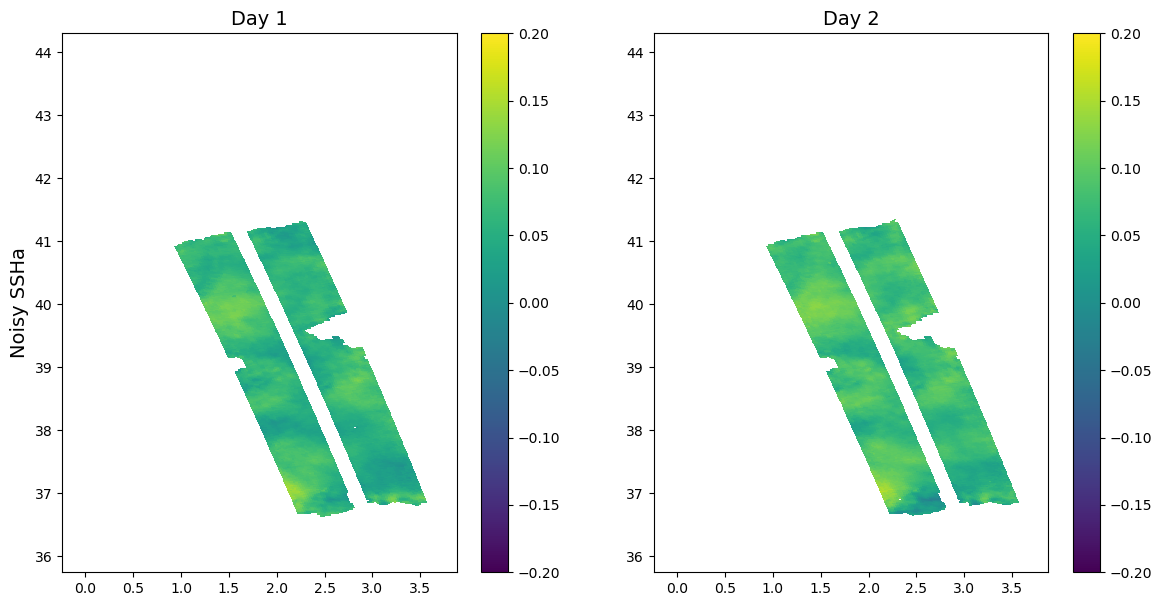

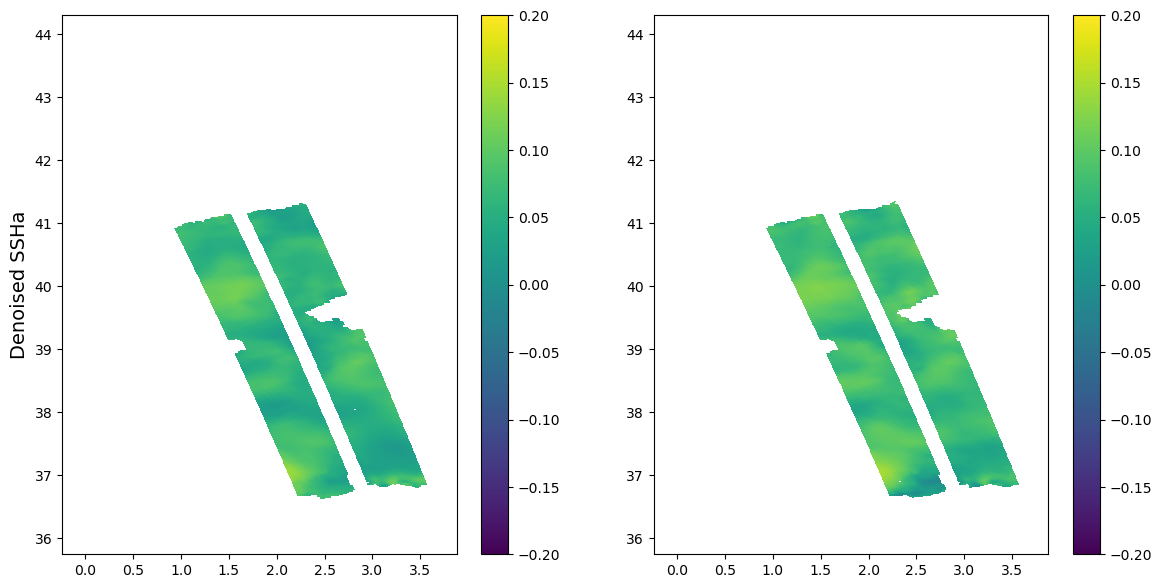

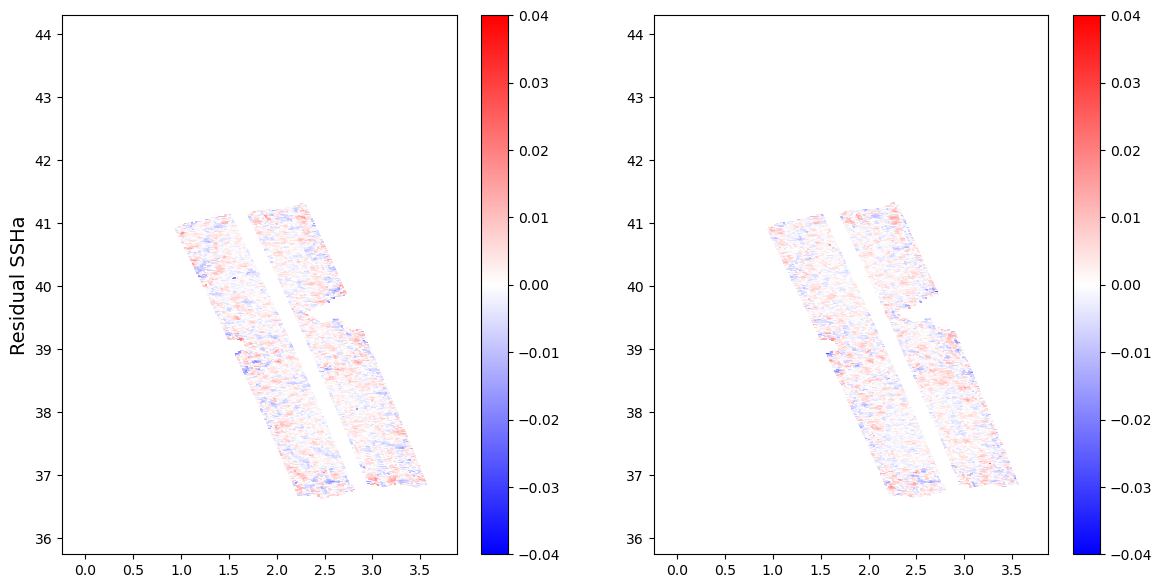

In [10]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.title('Day 1',fontsize=14)
plt.ylabel('Noisy SSHa',fontsize=14)
plt.pcolormesh(list_ds[2].longitude,list_ds[2].latitude,list_ds[2][var_ssha],vmin=-0.2,vmax=0.2)  
plt.colorbar()
plt.subplot(122)
plt.title('Day 2',fontsize=14)
plt.pcolormesh(list_ds[3].longitude,list_ds[3].latitude,list_ds[3][var_ssha],vmin=-0.2,vmax=0.2)  
plt.colorbar()

plt.figure(figsize=(14,7))
plt.subplot(121)
plt.ylabel('Denoised SSHa',fontsize=14)
plt.pcolormesh(list_ds[2].longitude,list_ds[0].latitude,list_ds[2][var_ssha_filtered],vmin=-0.2,vmax=0.2)   
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(list_ds[3].longitude,list_ds[3].latitude,list_ds[3][var_ssha_filtered],vmin=-0.2,vmax=0.2)   
plt.colorbar()

plt.figure(figsize=(14,7))
plt.subplot(121)
plt.ylabel('Residual SSHa',fontsize=14)
plt.pcolormesh(list_ds[2].longitude,list_ds[2].latitude,list_ds[2].residuals,cmap='bwr',vmin=-0.04,vmax=0.04) 
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(list_ds[3].longitude,list_ds[3].latitude,list_ds[3].residuals,cmap='bwr',vmin=-0.04,vmax=0.04) 
plt.colorbar()

plt.show()

In [11]:
list_cycle  = []
list_noise  = []
list_before = []
list_after  = []

for i in range(0, len(list_ds)-1): 
    cycle1 = int(list_ds[i].cycle_number[0].values)
    cycle2 = int(list_ds[i+1].cycle_number[0].values)
    list_cycle.append((cycle1+cycle2)/2)
    
    res1 = list_ds[i].residuals
    res2 = list_ds[i+1].residuals
    
    before1 = list_ds[i][var_ssha]
    before2 = list_ds[i+1][var_ssha]
    
    after1 = list_ds[i][var_ssha_filtered]
    after2 = list_ds[i+1][var_ssha_filtered]
    
    print('Cycle {} vs Cycle {} --------------------------------------'.format(cycle1, cycle2))
    list_noise.append(structural_similarity(res1, res2))
    print('    ds1 noise vs ds2 noise   : {:0.3f}'.format(list_noise[-1]))
    list_before.append(structural_similarity(before1, before2))
    print('    ds1 before vs ds2 before : {:0.3f}'.format(list_before[-1]))    
    list_after.append(structural_similarity(after1, after2))
    print('    ds1 after vs ds2 after   : {:0.3f}'.format(list_after[-1]))

Cycle 507 vs Cycle 508 --------------------------------------
    ds1 noise vs ds2 noise   : nan
    ds1 before vs ds2 before : nan
    ds1 after vs ds2 after   : nan
Cycle 508 vs Cycle 509 --------------------------------------
    ds1 noise vs ds2 noise   : nan
    ds1 before vs ds2 before : nan
    ds1 after vs ds2 after   : nan
Cycle 509 vs Cycle 510 --------------------------------------
    ds1 noise vs ds2 noise   : 0.580
    ds1 before vs ds2 before : 0.802
    ds1 after vs ds2 after   : 0.803
Cycle 510 vs Cycle 511 --------------------------------------
    ds1 noise vs ds2 noise   : 0.513
    ds1 before vs ds2 before : 0.823
    ds1 after vs ds2 after   : 0.831
Cycle 511 vs Cycle 512 --------------------------------------
    ds1 noise vs ds2 noise   : 0.540
    ds1 before vs ds2 before : 0.774
    ds1 after vs ds2 after   : 0.781
Cycle 512 vs Cycle 513 --------------------------------------
    ds1 noise vs ds2 noise   : nan
    ds1 before vs ds2 before : nan
    ds1 after v

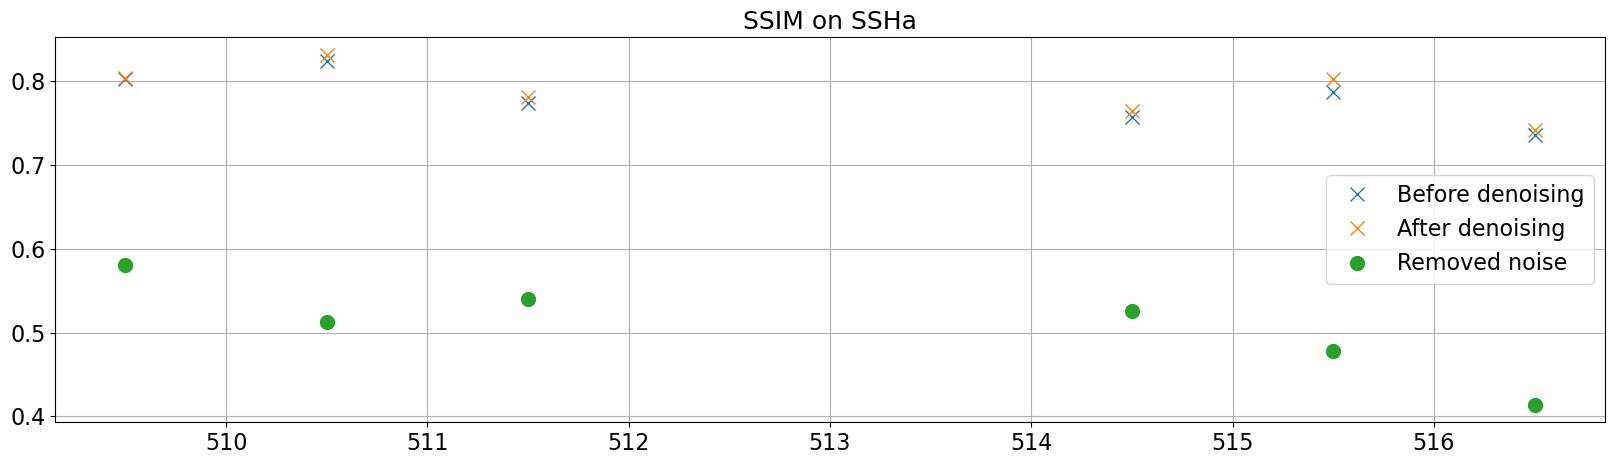

In [12]:
plt.figure(figsize = (20, 5))
plt.title('SSIM on SSHa', fontsize=18)
plt.plot(list_cycle, list_before, 'x', label = 'Before denoising', markersize=10)
plt.plot(list_cycle, list_after, 'x', label = 'After denoising', markersize=10)
plt.plot(list_cycle, list_noise, 'o', label = 'Removed noise', markersize=10)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.savefig('../figures/v102_'+region_info['name']+'/ssim_v102_'+region_info['name']+'_'+orbit+'_pass'+str(ipass)+'_ssh.png',bbox_inches='tight')
plt.show() 

In [13]:
print('SSI on SSH before out of',np.sum(~np.isnan(list_before)),'cycles on pass',ipass,':',np.nanmean(list_before))
print('SSI on SSH after out of',np.sum(~np.isnan(list_after)),'cycles on pass',ipass,':',np.nanmean(list_after))
print('SSI on SSH residual out of',np.sum(~np.isnan(list_noise)),'cycles on pass',ipass,':',np.nanmean(list_noise))

SSI on SSH before out of 6 cycles on pass 16 : 0.7797069498267426
SSI on SSH after out of 6 cycles on pass 16 : 0.7872303457317734
SSI on SSH residual out of 6 cycles on pass 16 : 0.508419391392869


## 5. Computing SSIM on velocities

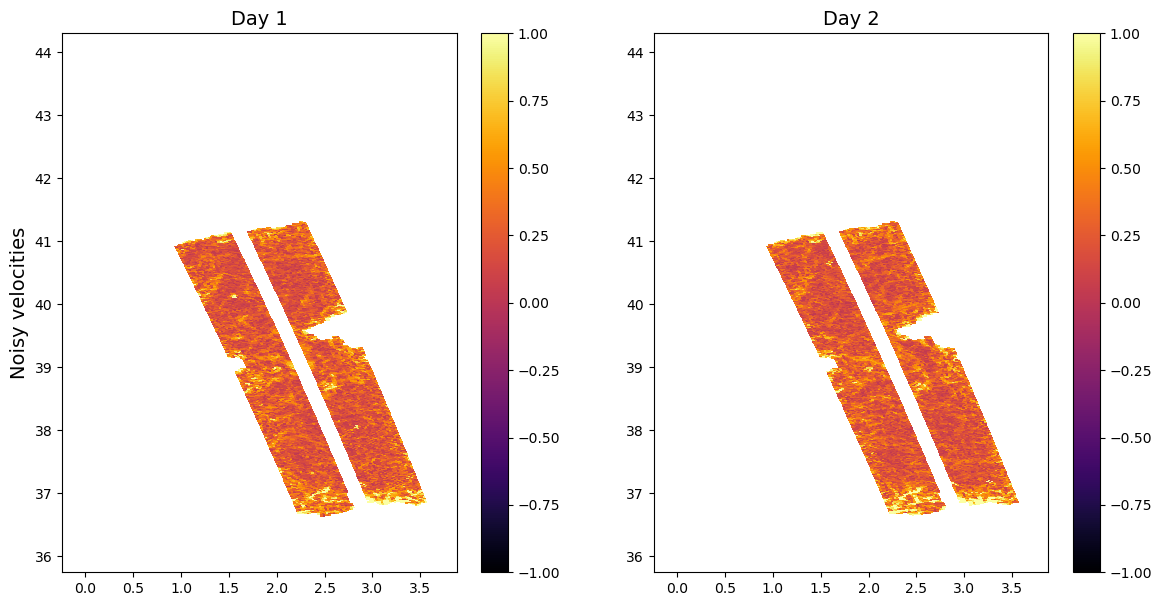

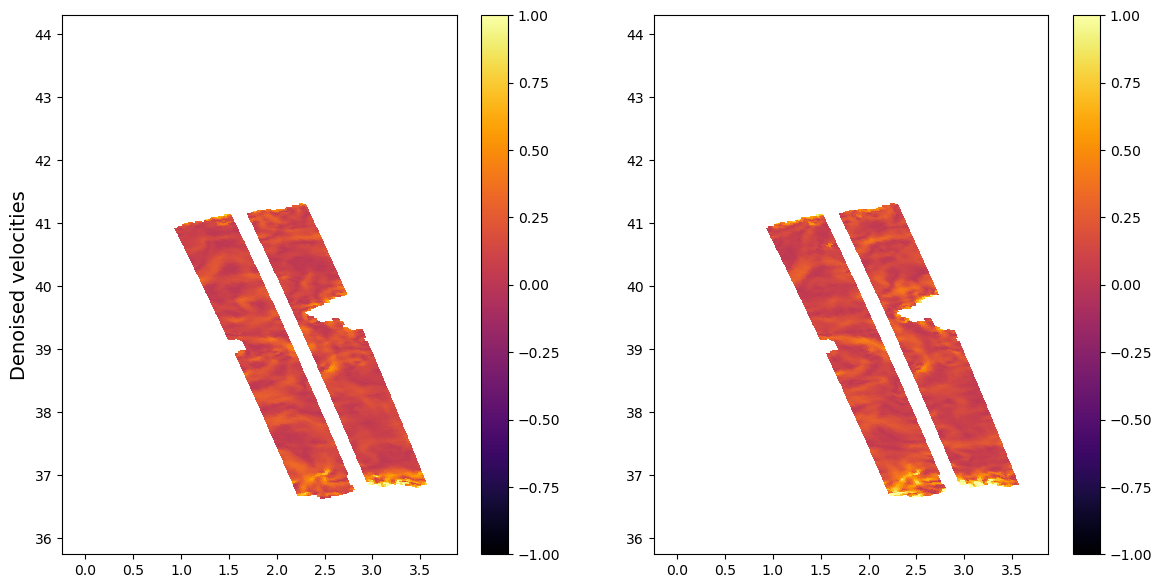

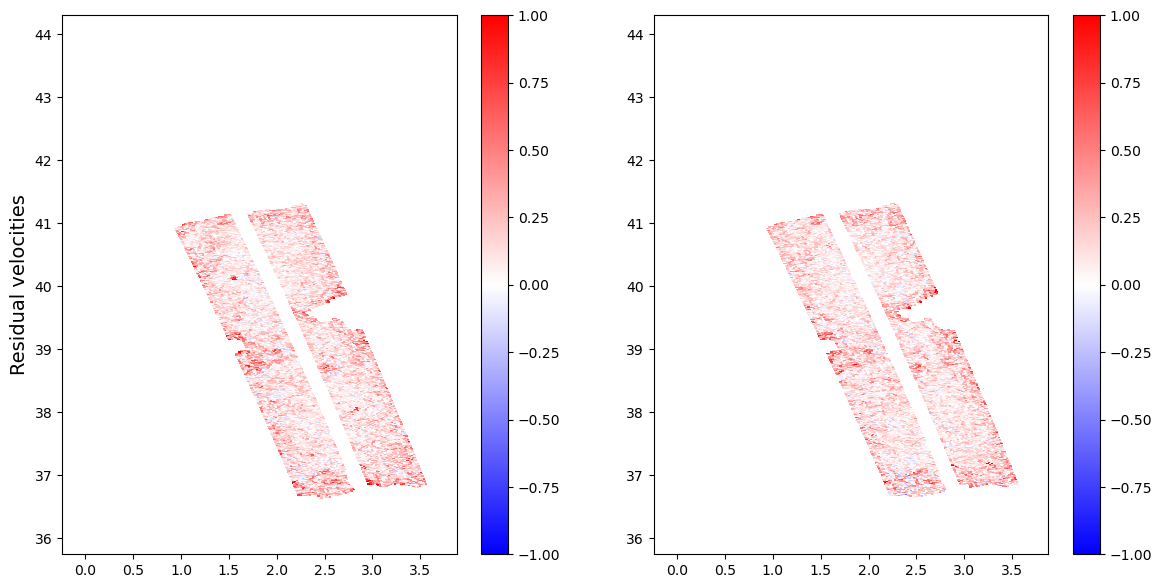

In [14]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.title('Day 1',fontsize=14)
plt.ylabel('Noisy velocities',fontsize=14)
plt.pcolormesh(list_ds[2].longitude,list_ds[2].latitude,list_ds[2].velocity_before, cmap='inferno',vmin=-1,vmax=1)
plt.colorbar()
plt.subplot(122)
plt.title('Day 2',fontsize=14)
plt.pcolormesh(list_ds[3].longitude,list_ds[3].latitude,list_ds[3].velocity_before, cmap='inferno',vmin=-1,vmax=1)
plt.colorbar()

plt.figure(figsize=(14,7))
plt.subplot(121)
plt.ylabel('Denoised velocities',fontsize=14)
plt.pcolormesh(list_ds[2].longitude,list_ds[2].latitude,list_ds[2].velocity_after, cmap='inferno',vmin=-1,vmax=1)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(list_ds[3].longitude,list_ds[3].latitude,list_ds[3].velocity_after, cmap='inferno',vmin=-1,vmax=1)
plt.colorbar()

plt.figure(figsize=(14,7))
plt.subplot(121)
plt.ylabel('Residual velocities',fontsize=14)
plt.pcolormesh(list_ds[2].longitude,list_ds[2].latitude,(list_ds[2].velocity_before-list_ds[2].velocity_after),cmap='bwr',vmin=-1,vmax=1) 
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(list_ds[3].longitude,list_ds[3].latitude,(list_ds[3].velocity_before-list_ds[3].velocity_after),cmap='bwr',vmin=-1,vmax=1) 
plt.colorbar()

plt.show()

In [15]:
list_noise_ug  = []
list_before_ug = []
list_after_ug  = []

for i in range(0, len(list_ds)-1): 
    cycle1 = int(list_ds[i].cycle_number[0].values)
    cycle2 = int(list_ds[i+1].cycle_number[0].values)

    before1 = list_ds[i].velocity_before
    #before1 = xr.where(np.abs(list_ds[i].latitude)<=6, np.nan, before1)
    before2 = list_ds[i+1].velocity_before
    #before2 = xr.where(np.abs(list_ds[i].latitude)<=6, np.nan, before2)
    
    after1 = list_ds[i].velocity_after
    #after1 = xr.where(np.abs(list_ds[i].latitude)<=6, np.nan, after1)
    after2 = list_ds[i+1].velocity_after
    #after2 = xr.where(np.abs(list_ds[i].latitude)<=6, np.nan, after2)
    
    res1 = before1 - after1
    res2 = before2 - after2
    
    print('Cycle {} vs Cycle {} --------------------------------------'.format(cycle1, cycle2))
    list_noise_ug.append(structural_similarity(res1, res2))
    print('    ds1 noise vs ds2 noise   : {:0.3f}'.format(list_noise_ug[-1]))
    list_before_ug.append(structural_similarity(before1, before2))      
    print('    ds1 before vs ds2 before : {:0.3f}'.format(list_before_ug[-1]))    
    list_after_ug.append(structural_similarity(after1, after2))
    print('    ds1 after vs ds2 after   : {:0.3f}'.format(list_after_ug[-1]))        

Cycle 507 vs Cycle 508 --------------------------------------
    ds1 noise vs ds2 noise   : nan
    ds1 before vs ds2 before : nan
    ds1 after vs ds2 after   : nan
Cycle 508 vs Cycle 509 --------------------------------------
    ds1 noise vs ds2 noise   : nan
    ds1 before vs ds2 before : nan
    ds1 after vs ds2 after   : nan
Cycle 509 vs Cycle 510 --------------------------------------
    ds1 noise vs ds2 noise   : 0.427
    ds1 before vs ds2 before : 0.622
    ds1 after vs ds2 after   : 0.747
Cycle 510 vs Cycle 511 --------------------------------------
    ds1 noise vs ds2 noise   : 0.422
    ds1 before vs ds2 before : 0.649
    ds1 after vs ds2 after   : 0.807
Cycle 511 vs Cycle 512 --------------------------------------
    ds1 noise vs ds2 noise   : 0.387
    ds1 before vs ds2 before : 0.606
    ds1 after vs ds2 after   : 0.775
Cycle 512 vs Cycle 513 --------------------------------------
    ds1 noise vs ds2 noise   : nan
    ds1 before vs ds2 before : nan
    ds1 after v

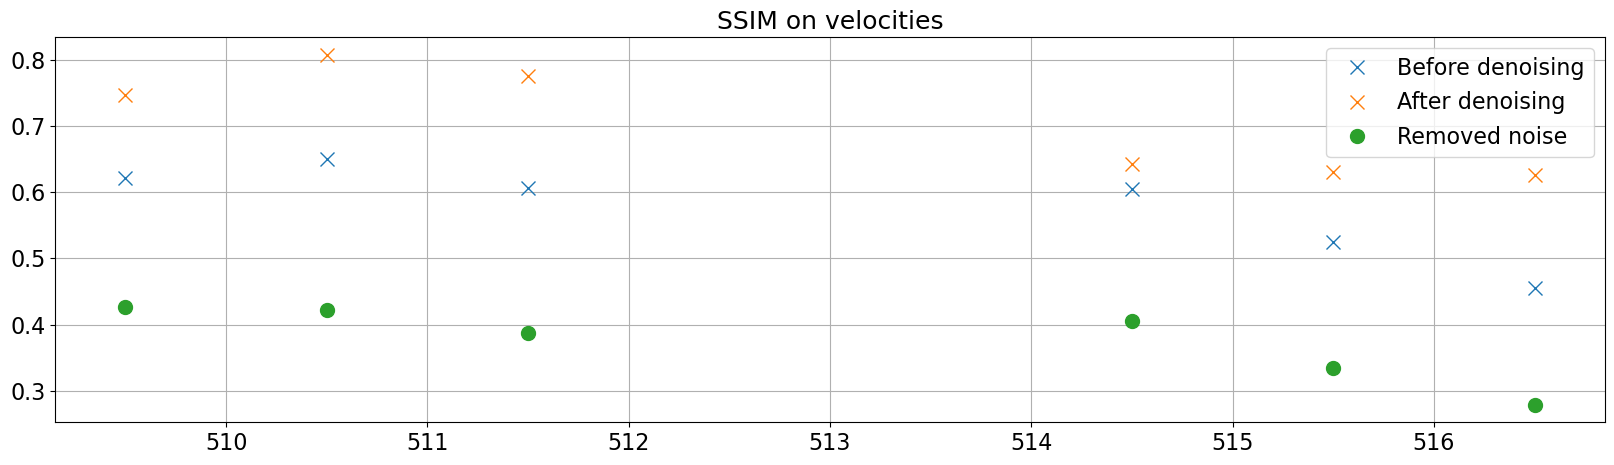

In [16]:
plt.figure(figsize = (20, 5))
plt.title('SSIM on velocities', fontsize=18)
plt.plot(list_cycle, list_before_ug, 'x', label = 'Before denoising', markersize=10)
plt.plot(list_cycle, list_after_ug, 'x', label = 'After denoising', markersize=10)
plt.plot(list_cycle, list_noise_ug, 'o', label = 'Removed noise', markersize=10)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.savefig('../figures/v102_'+region_info['name']+'/ssim_v102_'+region_info['name']+'_'+orbit+'_pass'+str(ipass)+'_vel.png',bbox_inches='tight')
plt.show()

In [17]:
print('SSI on velocity before out of',np.sum(~np.isnan(list_before_ug)),'cycles on pass',ipass,':',np.nanmean(list_before_ug))
print('SSI on velocity after out of',np.sum(~np.isnan(list_after_ug)),'cycles on pass',ipass,':',np.nanmean(list_after_ug))
print('SSI on velocity residual out of',np.sum(~np.isnan(list_noise_ug)),'cycles on pass',ipass,':',np.nanmean(list_noise_ug))

SSI on velocity before out of 6 cycles on pass 16 : 0.5772377985352556
SSI on velocity after out of 6 cycles on pass 16 : 0.7048935651465417
SSI on velocity residual out of 6 cycles on pass 16 : 0.3760369176266846


## 6. Computing SSIM on relative vorticity

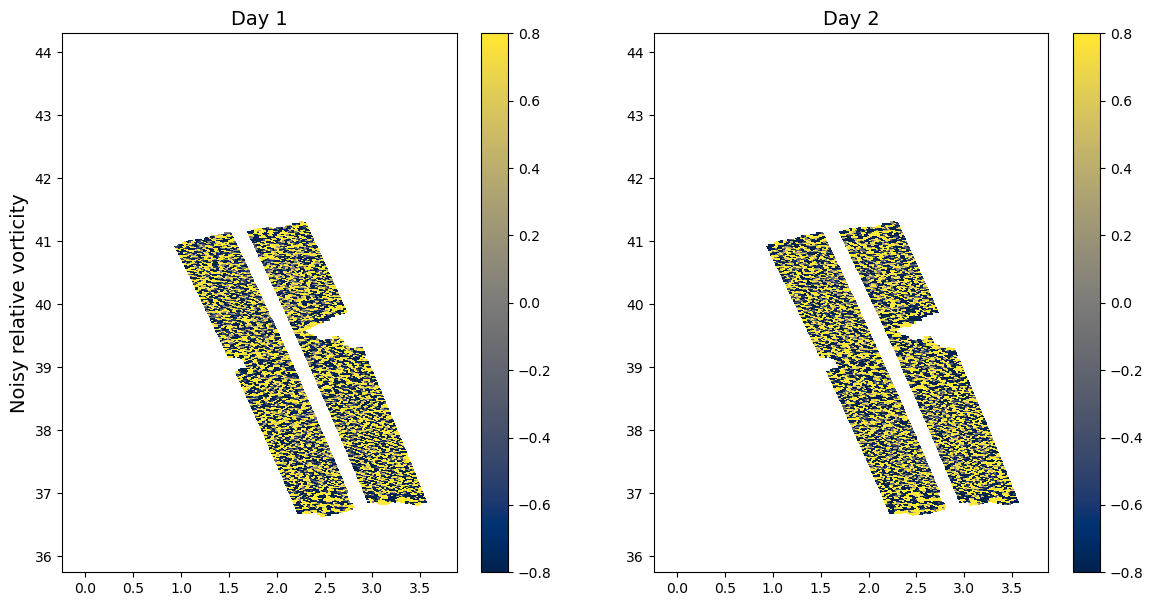

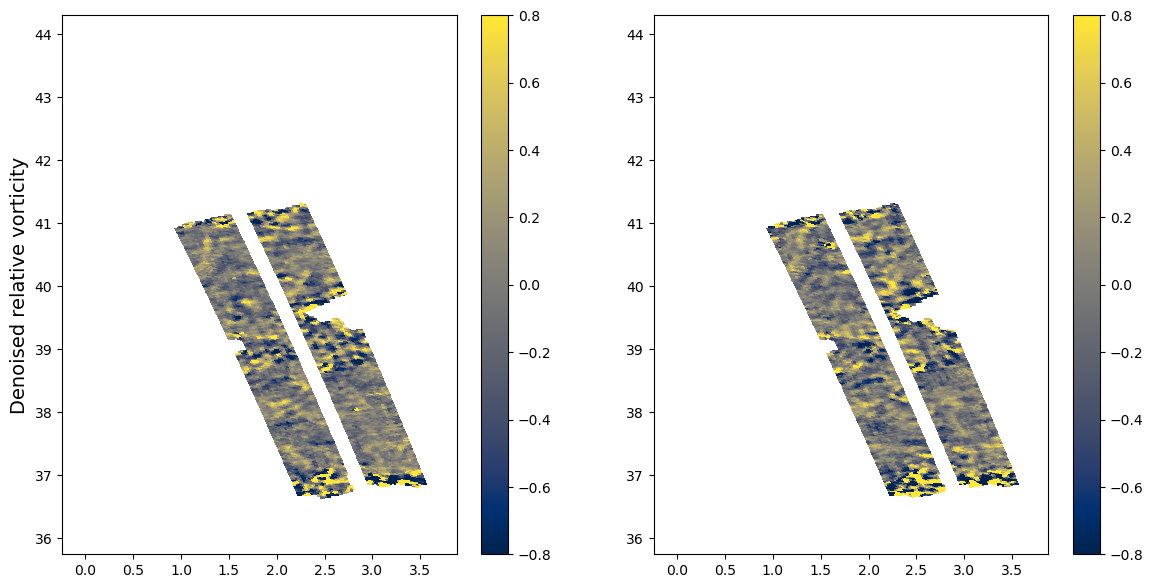

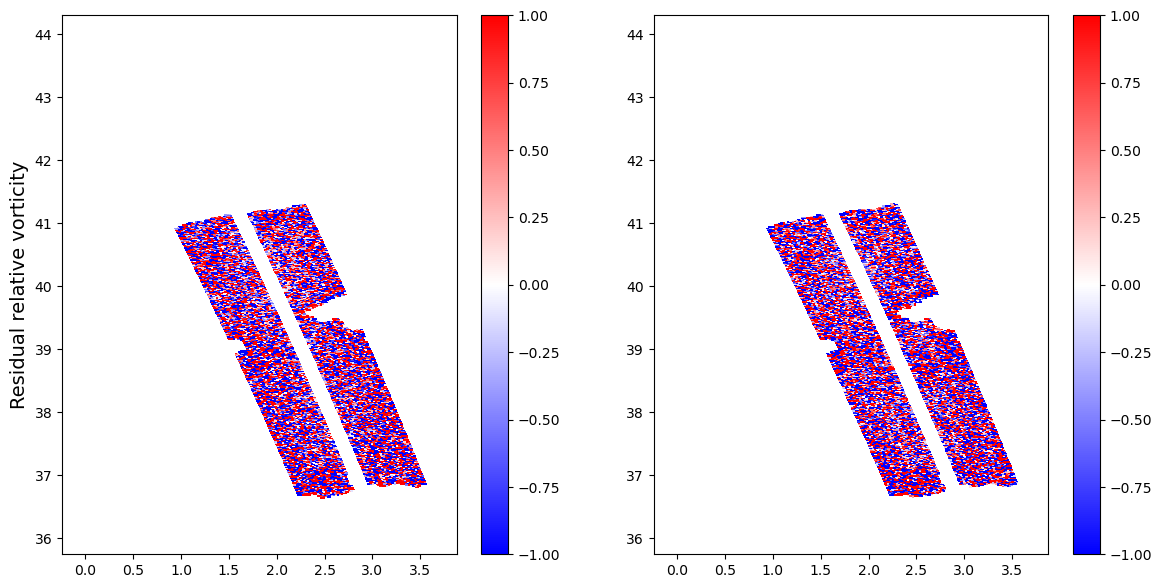

In [18]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.title('Day 1',fontsize=14)
plt.ylabel('Noisy relative vorticity',fontsize=14)
plt.pcolormesh(list_ds[2].longitude,list_ds[2].latitude,list_ds[2].relative_vorticity_before, cmap='cividis',vmin=-0.8,vmax=0.8)
plt.colorbar()
plt.subplot(122)
plt.title('Day 2',fontsize=14)
plt.pcolormesh(list_ds[3].longitude,list_ds[3].latitude,list_ds[3].relative_vorticity_before, cmap='cividis',vmin=-0.8,vmax=0.8)
plt.colorbar()

plt.figure(figsize=(14,7))
plt.subplot(121)
plt.ylabel('Denoised relative vorticity',fontsize=14)
plt.pcolormesh(list_ds[2].longitude,list_ds[2].latitude,list_ds[2].relative_vorticity_after, cmap='cividis',vmin=-0.8,vmax=0.8)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(list_ds[3].longitude,list_ds[1].latitude,list_ds[3].relative_vorticity_after, cmap='cividis',vmin=-0.8,vmax=0.8) 
plt.colorbar()

plt.figure(figsize=(14,7))
plt.subplot(121)
plt.ylabel('Residual relative vorticity',fontsize=14)
plt.pcolormesh(list_ds[2].longitude,list_ds[2].latitude,(list_ds[2].relative_vorticity_before-list_ds[2].relative_vorticity_after),cmap='bwr',vmin=-1,vmax=1) 
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(list_ds[3].longitude,list_ds[3].latitude,(list_ds[3].relative_vorticity_before-list_ds[3].relative_vorticity_after),cmap='bwr',vmin=-1,vmax=1) 
plt.colorbar()

plt.show()

In [19]:
list_noise_ksi  = []
list_before_ksi = []
list_after_ksi  = []

for i in range(0, len(list_ds)-1): 
    cycle1 = int(list_ds[i].cycle_number[0].values)
    cycle2 = int(list_ds[i+1].cycle_number[0].values)

    before1 = list_ds[i].relative_vorticity_before
    #before1 = xr.where(np.abs(list_ds[i].latitude)<=6, np.nan, before1)
    before2 = list_ds[i+1].relative_vorticity_before
    #before2 = xr.where(np.abs(list_ds[i].latitude)<=6, np.nan, before2)
    
    after1 = list_ds[i].relative_vorticity_after
    #after1 = xr.where(np.abs(list_ds[i].latitude)<=6, np.nan, after1)
    after2 = list_ds[i+1].relative_vorticity_after
    #after2 = xr.where(np.abs(list_ds[i].latitude)<=6, np.nan, after2)
    
    res1 = before1 - after1
    res2 = before2 - after2
    
    print('Cycle {} vs Cycle {} --------------------------------------'.format(cycle1, cycle2))
    list_noise_ksi.append(structural_similarity(res1, res2))
    print('    ds1 noise vs ds2 noise   : {:0.3f}'.format(list_noise_ksi[-1]))
    list_before_ksi.append(structural_similarity(before1, before2))
    print('    ds1 before vs ds2 before : {:0.3f}'.format(list_before_ksi[-1]))
    list_after_ksi.append(structural_similarity(after1, after2))
    print('    ds1 after vs ds2 after   : {:0.3f}'.format(list_after_ksi[-1]))        

Cycle 507 vs Cycle 508 --------------------------------------
    ds1 noise vs ds2 noise   : nan
    ds1 before vs ds2 before : nan
    ds1 after vs ds2 after   : nan
Cycle 508 vs Cycle 509 --------------------------------------
    ds1 noise vs ds2 noise   : nan
    ds1 before vs ds2 before : nan
    ds1 after vs ds2 after   : nan
Cycle 509 vs Cycle 510 --------------------------------------
    ds1 noise vs ds2 noise   : 0.374
    ds1 before vs ds2 before : 0.443
    ds1 after vs ds2 after   : 0.743
Cycle 510 vs Cycle 511 --------------------------------------
    ds1 noise vs ds2 noise   : 0.346
    ds1 before vs ds2 before : 0.441
    ds1 after vs ds2 after   : 0.749
Cycle 511 vs Cycle 512 --------------------------------------
    ds1 noise vs ds2 noise   : 0.324
    ds1 before vs ds2 before : 0.412
    ds1 after vs ds2 after   : 0.722
Cycle 512 vs Cycle 513 --------------------------------------
    ds1 noise vs ds2 noise   : nan
    ds1 before vs ds2 before : nan
    ds1 after v

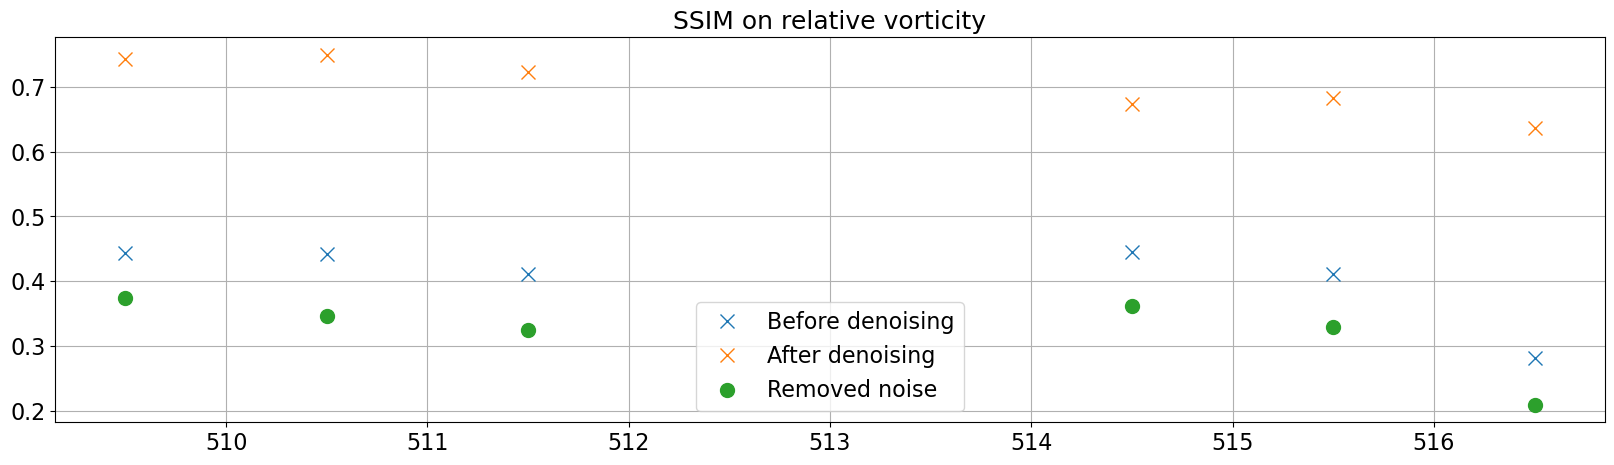

In [20]:
plt.figure(figsize = (20, 5))
plt.title('SSIM on relative vorticity', fontsize=18)
plt.plot(list_cycle, list_before_ksi, 'x', label = 'Before denoising', markersize=10)
plt.plot(list_cycle, list_after_ksi, 'x', label = 'After denoising', markersize=10)
plt.plot(list_cycle, list_noise_ksi, 'o', label = 'Removed noise', markersize=10)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.savefig('../figures/v102_'+region_info['name']+'/ssim_v102_'+region_info['name']+'_'+orbit+'_pass'+str(ipass)+'_relvort.png',bbox_inches='tight')
plt.show()

In [21]:
print('SSI on vorticity before out of',np.sum(~np.isnan(list_before_ksi)),'cycles on pass',ipass,':',np.nanmean(list_before_ksi))
print('SSI on vorticity after out of',np.sum(~np.isnan(list_after_ksi)),'cycles on pass',ipass,':',np.nanmean(list_after_ksi))
print('SSI on vorticity residual out of',np.sum(~np.isnan(list_noise_ksi)),'cycles on pass',ipass,':',np.nanmean(list_noise_ksi))

SSI on vorticity before out of 6 cycles on pass 16 : 0.4057911432072916
SSI on vorticity after out of 6 cycles on pass 16 : 0.7011896100958129
SSI on vorticity residual out of 6 cycles on pass 16 : 0.32399573157999817
